# Sun 2 and Black Hole Weather Analysis

Analyzing some statistics and blaseball game outcomes for Season 11 weather.

## Initial Setup

Start by importing stuff and setting up any variables.

In [1]:
import re
import os
import requests
import json
import sseclient
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from matplotlib._color_data import XKCD_COLORS as xkcd
xkcd = {k[5:] : v for k, v in xkcd.items()}

In [3]:
SEASON = 11
START_DAY = 1
END_DAY = 99

GAMES_DATA_JSON = 'games_data.json'

In [4]:
SEASON0 = SEASON - 1
START_DAY0 = START_DAY - 1
END_DAY0 = END_DAY - 1

## Import and Process Blaseball Game Data

We call the blaseball.com API (the `/games` endpoint) to get data about game outcomes.

We start by defining some functions that are useful for postprocessing the blaseball game data that we will get. Then we call the API and pass each game result through the postprocess function.

In [5]:
def save_game_data(gameData):
    with open(GAMES_DATA_JSON, 'w') as f:
        json.dump(gameData, f, indent=4, sort_keys=True)

def load_game_data():
    gameData = {}
    with open(GAMES_DATA_JSON, 'r') as f:
        gameData = json.load(f)
    return gameData

In [6]:
def postprocess_game_data(gameData):
    """Add derived quantities to make filtering easier"""
    DALE_SAFE = "Dale"
    DALE_UTF8 = "Dal\u00e9"

    FULL_DALE_SAFE = "Miami Dale"
    FULL_DALE_UTF8 = "Miami Dal\u00e9"

    trimGameData = []
    for game in gameData:
        trim = {}

        # For each game, create a new version of the game data
        # that drops extraneous keys, copies useful keys,
        # and creates new useful keys to view data by winner/loser
        # in addition to home/away.

        # Keys to keep:
        keep_keys = """
id
outcomes
awayPitcher
awayPitcherName
awayTeam
awayTeamName
awayTeamNickname
awayTeamColor
awayTeamEmoji
awayOdds
awayScore
homePitcher
homePitcherName
homeTeam
homeTeamName
homeTeamNickname
homeTeamColor
homeTeamEmoji
homeOdds
homeScore
season
isPostseason
day
phase
seriesIndex
seriesLength
shame
weather
homeBases
awayBases
repeatCount
playCount
"""
        keep_keys = [j.strip() for j in keep_keys.strip().split("\n")]

        for key in keep_keys:
            trim[key] = game[key]
            
        # Deal with Tokyo Lift emoji

        # Wings are not mild, ugh
        if 'Mild' in trim['homeTeamName']:
            trim['homeTeamName']='Mexico City Wild Wings'
            trim['homeTeamNickname']='Wild Wings'
        elif 'Mild' in trim['awayTeamName']:
            trim['awayTeamName']='Mexico City Wild Wings'
            trim['awayTeamNickname']='Wild Wings'

        # Always remove unicode in Dale (sanitized)
        # https://twitter.com/FHelltiger/status/1311795868622819329
        if trim['homeTeamName']==FULL_DALE_UTF8:
            trim['homeTeamName'] = FULL_DALE_SAFE
        elif trim['awayTeamName']==FULL_DALE_UTF8:
            trim['awayTeamName'] = FULL_DALE_SAFE

        # Add more keys here (hard-coded formulas)
        trim['runDiff'] = abs(game['homeScore'] - game['awayScore'])
        trim['whoWon'] = 'home' if game['homeScore'] > game['awayScore'] else 'away'
        
        # Season 11: deal with the Black Hole decree
        # - "real" runs means how many runs actually crossed the plate regardless of final score
        # - "apparent" runs means how many in the final score
        #
        # We count number of runs swallowed by Sun2 or BlackHole for home and away teams
        trim['homeScoreReal'] = int(trim['homeScore'])
        trim['awayScoreReal'] = int(trim['awayScore'])
        
        trim['homeSun2Wins'] = 0
        trim['homeSun2OpponentWins'] = 0
        trim['homeBlackHoleLostWins'] = 0
        trim['homeBlackHoleOpponentLostWins'] = 0
        
        trim['awaySun2Wins'] = 0
        trim['awaySun2OpponentWins'] = 0
        trim['awayBlackHoleLostWins'] = 0
        trim['awayBlackHoleOpponentLostWins'] = 0
        
        for outcome in trim['outcomes']:
            if 'sun 2' in outcome.lower():
                if trim['homeTeamNickname'] in outcome:
                    trim['homeScoreReal'] += 10
                    trim['homeSun2Wins'] += 1
                    trim['awaySun2OpponentWins'] += 1
                    
                elif trim['awayTeamNickname'] in outcome:
                    trim['awayScoreReal'] += 10
                    trim['awaySun2Wins'] += 1
                    trim['homeSun2OpponentWins'] += 1
                    
            elif 'black hole' in outcome.lower():
                if trim['homeTeamNickname'] in outcome:
                    trim['awayScoreReal'] += 10
                    # fixed these two (swap)
                    trim['homeBlackHoleLostWins'] += 1
                    trim['awayBlackHoleOpponentLostWins'] += 1
                    
                elif trim['awayTeamNickname'] in outcome:
                    trim['homeScoreReal'] += 10
                    # fixed these two (swap)
                    trim['awayBlackHoleLostWins'] += 1
                    trim['homeBlackHoleOpponentLostWins'] += 1

        # Now copy winning/losing versions of each of these keys
        add_keys = [
            'TeamName', 'TeamNickname', 'TeamEmoji', 'Score', 'Odds', 'PitcherName',
            'ScoreReal', 'Sun2Wins', 'Sun2OpponentWins', 'BlackHoleLostWins', 'BlackHoleOpponentLostWins'
        ]
        for key in add_keys:
            # Assign winning/losing a value from home/away as appropriate
            winning_key = "winning" + key
            losing_key = "losing" + key
            home_key = "home" + key
            away_key = "away" + key
            trim[winning_key] = trim[home_key] if game['homeScore'] > game['awayScore'] else trim[away_key]
            trim[losing_key] = trim[home_key] if game['homeScore'] < game['awayScore'] else trim[away_key]
        
        trimGameData.append(trim)

    return trimGameData

In [7]:
if not os.path.exists(GAMES_DATA_JSON):
    gameData = []
    for day0 in range(START_DAY0, END_DAY0+1):
        print(f"Now processing data for day {day0+1}")
        # Get the game data and postprocess it                                                            
        result = requests.get(f'https://www.blaseball.com/database/games?day={day0}&season={SEASON0}')
        result = result.json() 
        post_result = postprocess_game_data(result) 
        for game in post_result:  
            gameData.append(game) 
        # Save to file each time (slower but safer) 
        save_game_data(gameData)
else:
    gameData = load_game_data()

In [8]:
print(len(gameData))

990


In [9]:
print(json.dumps(gameData[2], indent=4, sort_keys=True))

{
    "awayBases": 4,
    "awayBlackHoleLostWins": 0,
    "awayBlackHoleOpponentLostWins": 0,
    "awayOdds": 0.4834948934915901,
    "awayPitcher": "e4e4c17d-8128-4704-9e04-f244d4573c4d",
    "awayPitcherName": "Wesley Poole",
    "awayScore": 2,
    "awayScoreReal": 2,
    "awaySun2OpponentWins": 0,
    "awaySun2Wins": 0,
    "awayTeam": "ca3f1c8c-c025-4d8e-8eef-5be6accbeb16",
    "awayTeamColor": "#8c2a3e",
    "awayTeamEmoji": "0x1F525",
    "awayTeamName": "Chicago Firefighters",
    "awayTeamNickname": "Firefighters",
    "day": 0,
    "homeBases": 4,
    "homeBlackHoleLostWins": 0,
    "homeBlackHoleOpponentLostWins": 0,
    "homeOdds": 0.5165051065084099,
    "homePitcher": "0295c6c2-b33c-47dd-affa-349da7fa1760",
    "homePitcherName": "Combs Estes",
    "homeScore": 4,
    "homeScoreReal": 4,
    "homeSun2OpponentWins": 0,
    "homeSun2Wins": 0,
    "homeTeam": "a37f9158-7f82-46bc-908c-c9e2dda7c33b",
    "homeTeamColor": "#6388ad",
    "homeTeamEmoji": "0x1F450",
    "homeTeam

## Analyze Data

Now it's time to put the games data in Pandas and start to analyze it.

In [10]:
df = pd.DataFrame.from_dict(gameData)
df = df.set_index('id')

In [11]:
df.head()

,awayBases,awayBlackHoleLostWins,awayBlackHoleOpponentLostWins,awayOdds,awayPitcher,awayPitcherName,awayScore,awayScoreReal,awaySun2OpponentWins,awaySun2Wins,...,winningBlackHoleOpponentLostWins,winningOdds,winningPitcherName,winningScore,winningScoreReal,winningSun2OpponentWins,winningSun2Wins,winningTeamEmoji,winningTeamName,winningTeamNickname
id,,,,,,,,,,,,,,,,,,,,,
9f4c7df5-cd95-492a-ac73-4a2242208855,4,0,0,0.582834,338694b7-6256-4724-86b6-3884299a5d9e,PolkaDot Patterson,0.0,0,0,0,...,0,0.417166,Yosh Carpenter,2.0,2,0,0,0x1F48B,San Francisco Lovers,Lovers
36fdc32a-8e14-43d6-9525-f30782dd4149,4,0,0,0.582077,5703141c-25d9-46d0-b680-0cf9cfbf4777,Sandoval Crossing,4.0,14,0,1,...,0,0.417923,Sixpack Santiago,5.0,5,1,0,0x1F6A4,Miami Dale,Dale
f3f4c236-b987-4a8c-96c6-acaa09dc7b44,4,0,0,0.483495,e4e4c17d-8128-4704-9e04-f244d4573c4d,Wesley Poole,2.0,2,0,0,...,0,0.516505,Combs Estes,4.0,4,0,0,0x1F450,Breckenridge Jazz Hands,Jazz Hands
1a4dba03-a55f-451c-8836-c0c22b1349df,4,0,0,0.319222,62ae6aa9-e346-4faa-b07c-1f7623580015,Gerund Pantheocide,1.0,1,0,0,...,0,0.680778,Alexandria Rosales,5.0,5,0,0,0x1F575,Houston Spies,Spies
cb69a541-914a-40e2-a545-4aa0ee3f71d3,4,0,0,0.597862,65273615-22d5-4df1-9a73-707b23e828d5,Burke Gonzales,2.0,2,0,0,...,0,0.402138,Mummy Melcon,3.0,3,0,0,0x1F405,Hades Tigers,Tigers


## Analyze Data by Team

We start by crunching numbers about Sun 2/Black Hole games for each team. Then we make plots of some interesting quantities.

In [12]:
teamNames = set()
for team in list(df['winningTeamNickname'].values) + list(df['losingTeamNickname'].values):
    teamNames.add(team)
teamNames = sorted(list(teamNames))

In [13]:
all_team_stats = []

for team in teamNames:

    team_stats = {}
    team_stats['Team'] = team
    
    # -----------
    # wins
    
    # apparent wins = wins according to final score
    apparent_wins = len(df[df['winningTeamNickname']==team])
    
    # apparent losses = real losses = plain old losses
    apparent_losses = len(df[df['losingTeamNickname']==team])
    
    # sun 2 wins
    s2w_from_wins = df.loc[df['winningTeamNickname']==team]['winningSun2Wins'].sum()
    s2w_from_losses =  df.loc[df['losingTeamNickname']==team]['losingSun2Wins'].sum()
    s2w = s2w_from_wins + s2w_from_losses
    
    # black hole lost wins
    bhlw_from_wins = df.loc[df['winningTeamNickname']==team]['winningBlackHoleLostWins'].sum()
    bhlw_from_losses = df.loc[df['losingTeamNickname']==team]['losingBlackHoleLostWins'].sum()
    bhlw = bhlw_from_wins + bhlw_from_losses
    
    # apparent wins (theirs)
    apparent_wins_theirs = apparent_losses
    apparent_losses_theirs = apparent_wins
    
    # sun 2 wins (theirs)
    s2w_theirs_from_our_wins = df.loc[df['winningTeamNickname']==team]['losingSun2Wins'].sum()
    s2w_theirs_from_our_losses =  df.loc[df['losingTeamNickname']==team]['winningSun2Wins'].sum()
    s2w_theirs = s2w_theirs_from_our_wins + s2w_theirs_from_our_losses
    
    # black hole lost wins (theirs)
    bhlw_theirs_from_our_wins = df.loc[df['winningTeamNickname']==team]['losingBlackHoleLostWins'].sum()
    bhlw_theirs_from_our_losses = df.loc[df['losingTeamNickname']==team]['winningBlackHoleLostWins'].sum()
    bhlw_theirs = bhlw_theirs_from_our_wins + bhlw_theirs_from_our_losses
    
    # real wins = win by final score, plus runs by sun 2, minus black hole lost wins
    real_wins = apparent_wins + s2w - bhlw_theirs    
    real_wins_theirs = apparent_wins_theirs + s2w_theirs - bhlw
    
    # -----------
    # runs
    
    # apparent runs = runs on the board at the end of the game
    apparent_runs_from_wins = df.loc[df['winningTeamNickname']==team]['winningScore'].sum()
    apparent_runs_from_losses = df.loc[df['losingTeamNickname']==team]['losingScore'].sum()
    apparent_runs = apparent_runs_from_wins + apparent_runs_from_losses
    
    # apparent runs theirs
    apparent_runs_theirs_from_our_wins = df.loc[df['winningTeamNickname']==team]['losingScore'].sum()
    apparent_runs_theirs_from_our_losses = df.loc[df['losingTeamNickname']==team]['winningScore'].sum()
    apparent_runs_theirs = apparent_runs_theirs_from_our_wins + apparent_runs_theirs_from_our_losses
    
    # runs eaten by sun 2
    s2r = s2w*10
    s2r_theirs = s2w_theirs*10
    
    # runs eaten by black hole
    bhr = bhlw*10
    bhr_theirs = bhlw_theirs*10

    # real runs = apparent plus sun 2 plus black hole theirs
    real_runs = apparent_runs + s2r + bhr
    real_runs_theirs = apparent_runs_theirs + s2r_theirs + bhr_theirs
    
    # -----------
    # stats
    
    team_stats['AW'] = apparent_wins
    team_stats['S2W'] = s2w
    team_stats['BHLW'] = bhlw
    team_stats['RW'] = real_wins
    
    team_stats['RWAWR'] = real_wins/apparent_wins
    
    team_stats['AWvs'] = apparent_wins_theirs
    team_stats['S2Wvs'] = s2w_theirs
    team_stats['BHLWvs'] = bhlw_theirs
    team_stats['RWvs'] = real_wins_theirs
    
    team_stats['RWAWRvs'] = real_wins_theirs/apparent_wins_theirs
    
    team_stats['L'] = apparent_losses
    team_stats['Lvs'] = apparent_losses_theirs
    
    team_stats['AR'] = apparent_runs
    team_stats['S2R'] = s2r
    team_stats['BHR'] = bhr
    team_stats['RR'] = real_runs
    
    team_stats['RRARR'] = real_runs/apparent_runs
    
    team_stats['ARvs'] = apparent_runs_theirs
    team_stats['S2Rvs'] = s2r_theirs
    team_stats['BHRvs'] = bhr_theirs
    team_stats['RRvs'] = real_runs_theirs
    
    team_stats['RRARRvs'] = real_runs_theirs/apparent_runs_theirs
    
    all_team_stats.append(team_stats)

all_team_stats_df = pd.DataFrame.from_dict(all_team_stats)

In [14]:
all_team_stats_df.head()

,Team,AW,S2W,BHLW,RW,RWAWR,AWvs,S2Wvs,BHLWvs,RWvs,...,AR,S2R,BHR,RR,RRARR,ARvs,S2Rvs,BHRvs,RRvs,RRARRvs
0,Breath Mints,43,7,5,49,1.139535,56,4,1,55,...,365.0,70,50,485.0,1.328767,390.0,40,10,440.0,1.128205
1,Dale,49,8,9,47,0.959184,50,19,10,60,...,457.0,80,90,627.0,1.371991,445.0,190,100,735.0,1.651685
2,Firefighters,56,8,5,61,1.089286,43,8,3,46,...,433.0,80,50,563.0,1.300231,410.0,80,30,520.0,1.268293
3,Flowers,48,10,10,48,1.000000,51,11,10,52,...,432.0,100,100,632.0,1.462963,467.0,110,100,677.0,1.449679
4,Fridays,47,2,0,44,0.936170,52,1,5,53,...,348.0,20,0,368.0,1.057471,360.0,10,50,420.0,1.166667


### Real Wins-Apparent Wins Ratio

Apparent win = win from having largest score at end

Real win = win from having largest score at end or from Sun 2

Lost win = win that is taken away by Black Hole

Real wins = apparent wins + sun 2 wins - black hole lost wins

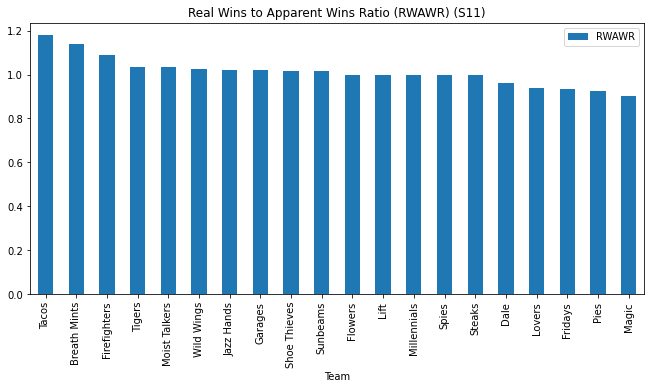

In [15]:
dat = all_team_stats_df[['Team', 'RWAWR']].sort_values(['RWAWR', 'Team'], ascending=[False, True])
ax = dat.plot.bar(x='Team', y='RWAWR')
ax.figure.set_figwidth(11)
ax.figure.set_figheight(5)
ax.set_title('Real Wins to Apparent Wins Ratio (RWAWR) (S11)')
plt.savefig('wins_01_rwawr.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

### Sun 2 Wins vs Black Hole Lost Wins

Wins coming from Sun 2, versus wins lost to the Black Hole

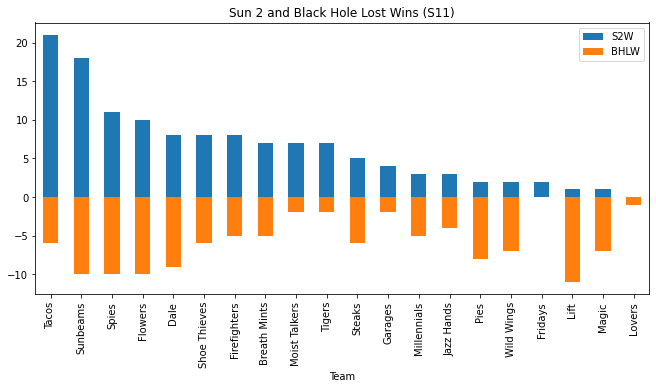

In [16]:
dat = all_team_stats_df[['Team', 'S2W', 'BHLW']]

# Invert BH lost wins
dat = dat.assign(BHLW=lambda x : -1.0*x['BHLW'])

# Sort by Sun 2 wins first, then BH lost wins
dat = dat.sort_values(['S2W','BHLW','Team'], ascending=[False, True, True])

ax = dat[['Team', 'S2W', 'BHLW']].plot.bar(x='Team', stacked=True)
ax.figure.set_figwidth(11)
ax.figure.set_figheight(5)
ax.set_title('Sun 2 and Black Hole Lost Wins (S11)')
plt.savefig('wins_02a_s2w_bhlw.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

In [17]:
dat[['Team', 'S2W']].iloc[0:5]

,Team,S2W
17,Tacos,21
16,Sunbeams,18
14,Spies,11
3,Flowers,10
1,Dale,8


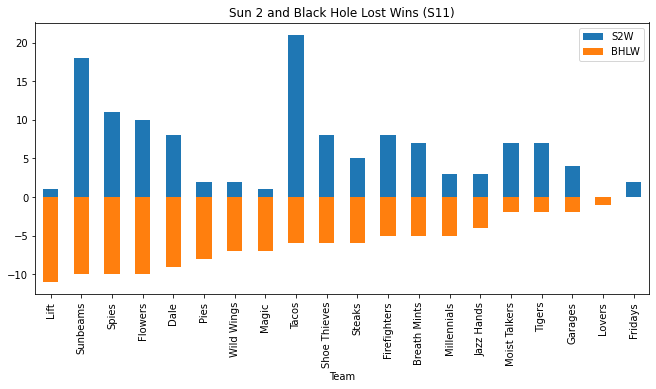

In [18]:
# Sort by BH lost wins first, then Sun 2 wins
dat = dat.sort_values(['BHLW','S2W','Team'], ascending=[True, False, True])

ax = dat[['Team', 'S2W', 'BHLW']].plot.bar(x='Team', stacked=True)
ax.figure.set_figwidth(11)
ax.figure.set_figheight(5)
ax.set_title('Sun 2 and Black Hole Lost Wins (S11)')
plt.savefig('wins_02b_s2w_bhlw.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

In [19]:
dat[['Team', 'BHLW']].iloc[0:5]

,Team,BHLW
7,Lift,-11.0
16,Sunbeams,-10.0
14,Spies,-10.0
3,Flowers,-10.0
1,Dale,-9.0


### Sun 2 Wins by Team vs Sun 2 Wins by Opponents

This shows the number of Sun 2 wins bestowed on a team, versus the number of Sun 2 wins bestowed on the opponent.

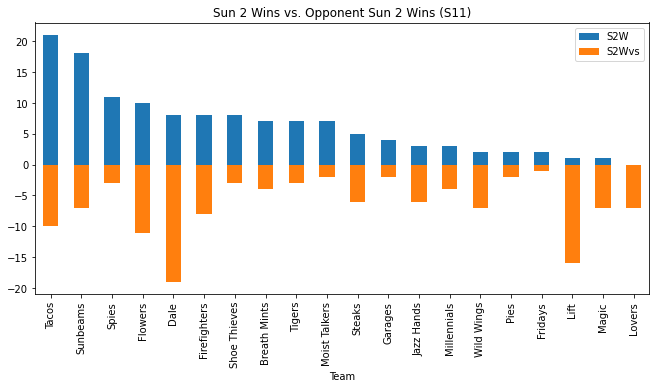

In [20]:
dat = all_team_stats_df[['Team', 'S2W', 'S2Wvs']]

# Invert
dat = dat.assign(S2Wvs=lambda x : -1.0*x['S2Wvs'])

# Sort
dat = dat.sort_values(['S2W','S2Wvs', 'Team'], ascending=[False, True, True])

ax = dat.plot.bar(x='Team', stacked=True)
ax.figure.set_figwidth(11)
ax.figure.set_figheight(5)
ax.set_title('Sun 2 Wins vs. Opponent Sun 2 Wins (S11)')
plt.savefig('wins_03a_s2w_vs.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

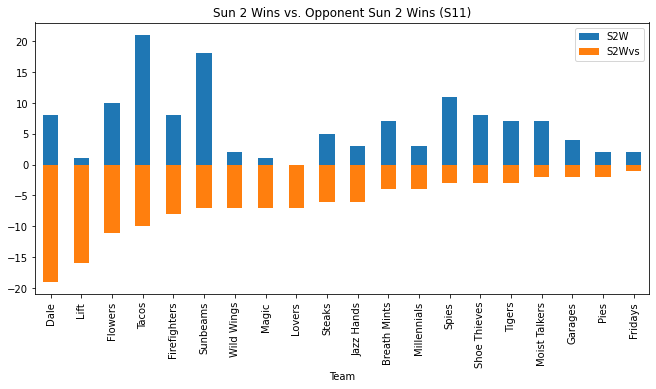

In [21]:
# Sort
dat = dat.sort_values(['S2Wvs','S2W', 'Team'], ascending=[True, False, True])

ax = dat.plot.bar(x='Team', stacked=True)
ax.figure.set_figwidth(11)
ax.figure.set_figheight(5)
ax.set_title('Sun 2 Wins vs. Opponent Sun 2 Wins (S11)')
plt.savefig('wins_03b_s2w_vs.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

In [22]:
dat[['Team', 'S2Wvs']].iloc[0:5]

,Team,S2Wvs
1,Dale,-19.0
7,Lift,-16.0
3,Flowers,-11.0
17,Tacos,-10.0
2,Firefighters,-8.0


### Black Hole Lost Wins by Team vs. Black Hole Lost Wins by Opponents

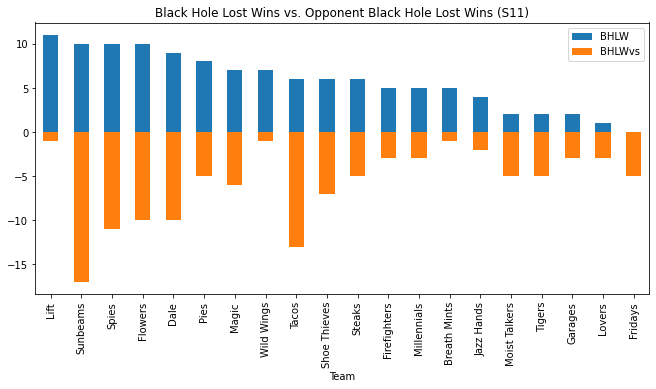

In [23]:
dat = all_team_stats_df[['Team', 'BHLW', 'BHLWvs']]

# Invert
dat = dat.assign(BHLWvs=lambda x : -1.0*x['BHLWvs'])

# Sort
dat = dat.sort_values(['BHLW','BHLWvs', 'Team'], ascending=[False, True, True])

ax = dat.plot.bar(x='Team', stacked=True)
ax.figure.set_figwidth(11)
ax.figure.set_figheight(5)
ax.set_title('Black Hole Lost Wins vs. Opponent Black Hole Lost Wins (S11)')
plt.savefig('wins_04a_bhlw_vs.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

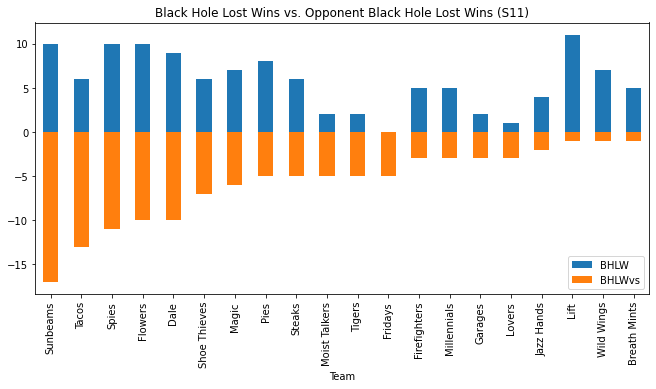

In [24]:
# Sort
dat = dat.sort_values(['BHLWvs','BHLW', 'Team'], ascending=[True, False, True])

ax = dat.plot.bar(x='Team', stacked=True)
ax.figure.set_figwidth(11)
ax.figure.set_figheight(5)
ax.set_title('Black Hole Lost Wins vs. Opponent Black Hole Lost Wins (S11)')
plt.savefig('wins_04b_bhlw_vs.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

In [25]:
dat[['Team', 'BHLWvs']].iloc[0:5]

,Team,BHLWvs
16,Sunbeams,-17.0
17,Tacos,-13.0
14,Spies,-11.0
3,Flowers,-10.0
1,Dale,-10.0


### Real Wins vs. Apparent Wins

Apparent wins = wins coming from having highest score at end of game

Real wins = apparent wins plus Sun 2 wins minus Black Hole lost wins

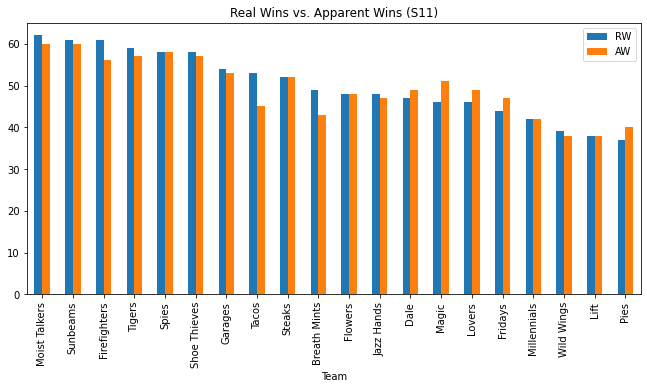

In [26]:
dat = all_team_stats_df[['Team', 'RW', 'AW']]

# Sort
dat = dat.sort_values(['RW','AW', 'Team'], ascending=[False, False, True])

ax = dat.plot.bar(x='Team')
ax.figure.set_figwidth(11)
ax.figure.set_figheight(5)
ax.set_title('Real Wins vs. Apparent Wins (S11)')
plt.savefig('wins_05_rwaw.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

### Real Runs-Apparent Runs Ratio

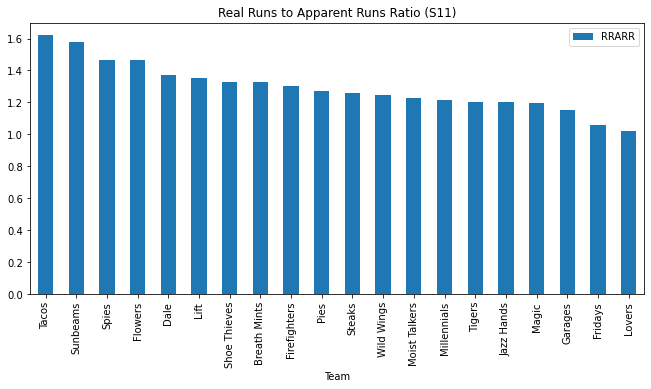

In [27]:
dat = all_team_stats_df[['Team', 'RRARR']].sort_values(['RRARR', 'Team'], ascending=[False, True])
ax = dat.plot.bar(x='Team', y='RRARR')
ax.figure.set_figwidth(11)
ax.figure.set_figheight(5)
ax.set_title('Real Runs to Apparent Runs Ratio (S11)')
plt.savefig('runs_01_rrarr.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

### Sun 2 Runs and Black Hole Runs

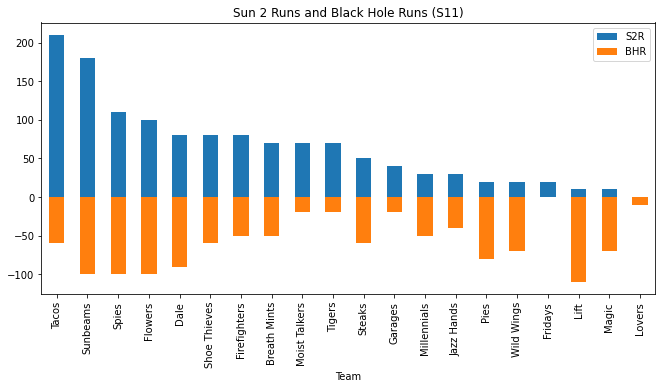

In [28]:
dat = all_team_stats_df[['Team', 'S2R', 'BHR']]

# Invert BH lost wins
dat = dat.assign(BHR=lambda x : -1.0*x['BHR'])

dat = dat.sort_values(['S2R','BHR','Team'], ascending=[False, True, True])

ax = dat[['Team', 'S2R', 'BHR']].plot.bar(x='Team', stacked=True)
ax.figure.set_figwidth(11)
ax.figure.set_figheight(5)
ax.set_title('Sun 2 Runs and Black Hole Runs (S11)')
plt.savefig('runs_02a_s2w_bhlw.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

In [29]:
dat[['Team', 'S2R']].iloc[0:5]

,Team,S2R
17,Tacos,210
16,Sunbeams,180
14,Spies,110
3,Flowers,100
1,Dale,80


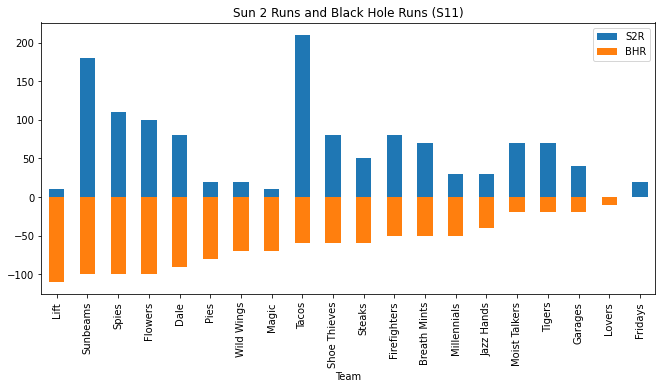

In [30]:
dat = dat.sort_values(['BHR','S2R','Team'], ascending=[True, False, True])

ax = dat[['Team', 'S2R', 'BHR']].plot.bar(x='Team', stacked=True)
ax.figure.set_figwidth(11)
ax.figure.set_figheight(5)
ax.set_title('Sun 2 Runs and Black Hole Runs (S11)')
plt.savefig('runs_02b_s2w_bhlw.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

In [31]:
dat[['Team', 'BHR']].iloc[0:5]

,Team,BHR
7,Lift,-110.0
16,Sunbeams,-100.0
14,Spies,-100.0
3,Flowers,-100.0
1,Dale,-90.0


### Sun 2 Runs by Team vs. Sun 2 Runs by Opponent

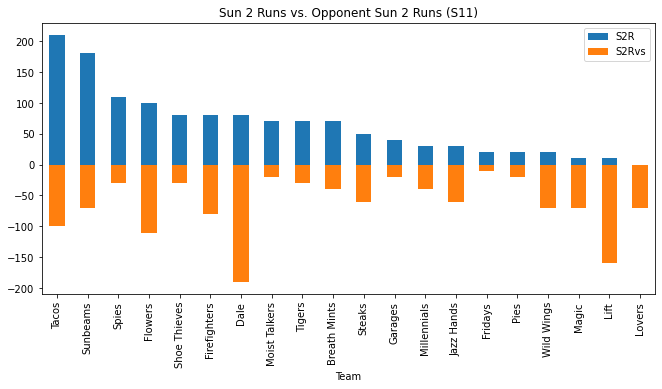

In [32]:
dat = all_team_stats_df[['Team', 'S2R', 'S2Rvs']]

# Invert
dat = dat.assign(S2Rvs=lambda x : -1.0*x['S2Rvs'])

dat = dat.sort_values(['S2R','S2Rvs', 'Team'], ascending=[False, False, True])

ax = dat.plot.bar(x='Team', stacked=True)
ax.figure.set_figwidth(11)
ax.figure.set_figheight(5)
ax.set_title('Sun 2 Runs vs. Opponent Sun 2 Runs (S11)')
plt.savefig('runs_03a_s2w_vs.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

In [ ]:
dat = dat.sort_values(['S2Rvs','S2R', 'Team'], ascending=[True, False, True])

ax = dat.plot.bar(x='Team', stacked=True)
ax.figure.set_figwidth(11)
ax.figure.set_figheight(5)
ax.set_title('Sun 2 Runs vs. Opponent Sun 2 Runs (S11)')
plt.savefig('runs_03b_s2w_vs.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

In [ ]:
dat[['Team', 'S2Rvs']].iloc[0:5]

### Black Hole Runs by Team vs. Black Hole Runs by Opponent

In [ ]:
dat = all_team_stats_df[['Team', 'BHR', 'BHRvs']]

# Invert
dat = dat.assign(BHRvs=lambda x : -1.0*x['BHRvs'])

dat = dat.sort_values(['BHR','BHRvs', 'Team'], ascending=[False, True, True])

ax = dat.plot.bar(x='Team', stacked=True)
ax.figure.set_figwidth(11)
ax.figure.set_figheight(5)
ax.set_title('Black Hole Lost Wins vs. Opponent Black Hole Lost Wins (S11)')
plt.savefig('runs_04a_bhlw_vs.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

In [ ]:
dat = dat.sort_values(['BHRvs','BHR', 'Team'], ascending=[True, False, True])

ax = dat.plot.bar(x='Team', stacked=True)
ax.figure.set_figwidth(11)
ax.figure.set_figheight(5)
ax.set_title('Black Hole Lost Wins vs. Opponent Black Hole Lost Wins (S11)')
plt.savefig('runs_04b_bhlw_vs.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

In [ ]:
dat[['Team', 'BHRvs']].iloc[0:5]

### Real Wins vs. Apparent Wins and Real Runs vs. Apparent Runs

Same order of teams, for easier comparison.

In [ ]:
dat = all_team_stats_df[['Team', 'RR', 'AR', 'RW', 'AW']]

dat = dat.sort_values(['RR','AR', 'Team'], ascending=[False, False, True])

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

fig.set_figwidth(12)
fig.set_figheight(8)

dat[['Team', 'RW', 'AW']].plot.bar(x='Team', ax=ax1)
ax1.set_title('Real Wins vs. Apparent Wins(S11 thru day %s)'%(END_DAY))

dat[['Team', 'RR', 'AR']].plot.bar(x='Team', ax=ax2)
ax2.set_title('Real Runs vs. Apparent Runs (S11 thru day %s)'%(END_DAY))

plt.savefig('rwaw_rrarr.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

In [ ]:
dat = all_team_stats_df[['Team', 'RR', 'AR']]
dat = dat.assign(diff=dat.apply(lambda x: x['RR'] - x['AR'], axis=1))
dat = dat.sort_values(['diff', 'Team'], ascending=[False, True])
dat[['Team', 'diff']].iloc[:5]

## How Much Weather

In [ ]:
weather = []

for team in teamNames:
    w = {}
    w['Team'] = team
    
    team_dat = df.loc[(df['winningTeamNickname']==team) | (df['losingTeamNickname']==team)]
    weather_counts = team_dat['weather'].value_counts()
    w['Sun 2 Pct'] = 100*weather_counts.loc[1]/(END_DAY - START_DAY)
    w['Black Hole Pct'] = 100*weather_counts.loc[14]/(END_DAY - START_DAY)
    weather.append(w)

weather_df = pd.DataFrame.from_dict(weather)

In [ ]:
weather_df = weather_df.sort_values('Sun 2 Pct', ascending=False)

ax = weather_df[['Team', 'Black Hole Pct', 'Sun 2 Pct']].plot.bar(x='Team', stacked=True)
ax.figure.set_figwidth(11)
ax.figure.set_figheight(5)
ax.axhline(y=50, linestyle='--', color='black')
ax.set_title('Fraction of Games Played in Each Weather (S11 thru day %s)'%(END_DAY))

plt.savefig('weather_pct_teams.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

## Score Histograms

Now we analyze score histogram data. That is, we look at the distribution of number of runs scored by each team, split by wins and losses.

In [ ]:
score_histograms = []

for team in teamNames:

    team_histogram = {}
    team_histogram['Team'] = team
    
    winning_scores = df.loc[df['winningTeamNickname']==team]['winningScore'].values
    losing_scores = df.loc[df['losingTeamNickname']==team]['losingScore'].values
    
    team_histogram['Winning Scores'] = winning_scores
    team_histogram['Losing Scores'] = losing_scores

    score_histograms.append(team_histogram)

score_hist_df = pd.DataFrame.from_dict(score_histograms)

In [ ]:
score_hist_df.head()

In [ ]:
#xkcd.keys()

In [ ]:
fig, axes = plt.subplots(5, 4, sharex=False)

fig.set_figwidth(18)
fig.set_figheight(20)

for i, row in score_hist_df.iterrows():
    
    ir = i//4
    ic = i%4
    
    ax = axes[ir, ic]

    ax.hist(row['Winning Scores'], density=True, color=xkcd['orange'], alpha=0.4, bins=5, label='Winning Scores')
    ax.hist(row['Losing Scores'], density=True, color=xkcd['purple'], alpha=0.4, bins=5, label='Losing Scores')
    ax.set_xlabel(row['Team'])
    ax.set_ylim([0,0.40])
    if ic==0 and ir==0:
        ax.legend()

fig.suptitle('Histograms of Final Runs Scores (S11)')

plt.savefig('hist_final_scores_teams.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, sharex=False)
fig.set_figwidth(10)
fig.set_figheight(6)

ax.hist(df['winningScore'].values, density=True, color=xkcd['orange'], alpha=0.4, bins=9, label='Apparent Wins')
ax.hist(df['losingScore'].values, density=True, color=xkcd['purple'], alpha=0.4, bins=9, label='Apparent Losses')
ax.set_title('Score Histogram')
ax.set_xlabel('Number of Runs in Final Score')
ax.set_ylabel('Frequency')

plt.legend()

plt.savefig('hist_final_scores_overall.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

## Weather Effects on Win-Loss Record

Here we explore what would have happened if there had been no weather, and runs counted the way they normally do.

What would teams' records be? How many games did weather overturn?

In [ ]:
keepcols = [
    'day',
    'weather',
    'winningTeamNickname',
    'winningScoreReal',
    'winningScore',
    'winningSun2Wins',
    'winningBlackHoleLostWins',
    'losingTeamNickname',
    'losingScoreReal',
    'losingScore',
    'losingSun2Wins',
    'losingBlackHoleLostWins',
]

In [ ]:
print(df['winningSun2Wins'].unique())
print(df['winningBlackHoleLostWins'].unique())

In [ ]:
winloss = []

for team in teamNames:
    team_df = df.loc[(df['winningTeamNickname']==team) | (df['losingTeamNickname']==team)]
    team_df = team_df.sort_values(['day'], ascending=True)
    
    # Accumulate
    AW = 0
    AL = 0
    RW = 0
    FW = 0
    FL = 0
    
    for game_id, game in team_df.iterrows():
        
        w = {}
        w['Team'] = team
        
        outcome_reversed = False
        
        if game['winningTeamNickname']==team:
            
            AW += 1
            RW += 1
            
            if game['winningSun2Wins'] > 0:
                RW += game['winningSun2Wins']
            elif game['winningBlackHoleLostWins'] > 0:
                RW -= game['winningBlackHoleLostWins']
            
            if game['winningScoreReal'] > game['losingScoreReal']:
                FW += 1
            else:
                FL += 1
                outcome_reversed = True
            
        else:
            
            AL += 1
            if game['losingSun2Wins'] > 0:
                RW += game['losingSun2Wins']
            elif game['losingBlackHoleLostWins'] > 0:
                RW -= game['losingBlackHoleLostWins']
        
            if game['losingScoreReal'] > game['winningScoreReal']:
                FW += 1
                outcome_reversed = True
            else:
                FL += 1
        
        AGA500 = AW - AL
        RGA500 = RW - AL
        FGA500 = FW - FL
        
        AGA500b = AW - (game['day']//2)
        RGA500b = RW - (game['day']//2)
        FGA500b = FW - (game['day']//2)
        
        #print(game['day'])
        w['Day'] = game['day']
        w['OutcomeReversed'] = outcome_reversed
        w['AW'] = AW
        w['AL'] = AL
        w['RW'] = RW
        w['FW'] = FW
        w['FL'] = FL
        
        w['AGA500'] = AGA500
        w['RGA500'] = RGA500
        w['FGA500'] = FGA500
        
        w['AGA500b'] = AGA500b
        w['RGA500b'] = RGA500b
        w['FGA500b'] = FGA500b
        
        w['AGA500-FGA500-Diff'] = AGA500 - FGA500
        w['RGA500-FGA500-Diff'] = RGA500 - FGA500
        
        w['AGA500b-FGA500b-Diff'] = AGA500b - FGA500b
        w['RGA500b-FGA500b-Diff'] = RGA500b - FGA500b
        
        winloss.append(w)

winloss_df = pd.DataFrame.from_dict(winloss)

In [ ]:
winloss_df.head()

In [ ]:
z = winloss_df.loc[winloss_df['Team']=='Tacos']
z.loc[z['Day']==98]

In [ ]:
z = winloss_df.loc[winloss_df['Team']=='Sunbeams']
z.loc[z['Day']==98]

In [ ]:
z = winloss_df.loc[winloss_df['Team']=='Garages']
z.loc[z['Day']==98]

In [ ]:
z = winloss_df.loc[winloss_df['Team']=='Breath Mints']
z.loc[z['Day']==98]

In [ ]:
z = winloss_df.loc[winloss_df['Team']=='Pies']
z.loc[z['Day']==98]

In [ ]:
z = winloss_df.loc[winloss_df['Team']=='Lift']
z.loc[z['Day']==98]

In [ ]:
z = winloss_df.loc[winloss_df['Team']=='Fridays']
z.loc[z['Day']==98]

In [ ]:
beams_wl_df = winloss_df.loc[winloss_df['Team']=='Sunbeams']

In [ ]:
ax = beams_wl_df[['Day', 'AGA500', 'RGA500', 'FGA500']].plot(
    x='Day',
    color=[xkcd['dark green'], xkcd['dark blue'], xkcd['dark orange']]
)
ax.set_title('Beams W/L Record: Over .500')
ax.fill_between(
    beams_wl_df['Day'], 
    beams_wl_df['FGA500'], 
    0,
    alpha=0.4, 
    color=xkcd['light orange']
)

plt.savefig('ga500_00_aga_rga_fga_beams.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

In [ ]:
ax = beams_wl_df[['Day', 'AGA500-FGA500-Diff', 'RGA500-FGA500-Diff']].plot(
    x='Day',
    color=[xkcd['dark purple'], xkcd['dark red']],
)
ax.set_title('Beams W/L Record: Differential Btwn Actual-Fair/Real-Fair Over .500')
ax.fill_between(
    beams_wl_df['Day'], 
    beams_wl_df['RGA500-FGA500-Diff'], 
    0,
    alpha=0.4, 
    color=xkcd['dusty red']
)

plt.savefig('ga500_00_diff_beams.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

In [ ]:
fig, axes = plt.subplots(5, 4, sharex=False)

fig.set_figwidth(18)
fig.set_figheight(20)

for i, team in enumerate(teamNames):
    
    team_df = winloss_df.loc[winloss_df['Team']==team]
    
    ir = i//4
    ic = i%4
    
    ax = axes[ir, ic]
    
    team_df[['Day', 'AGA500']].plot(
        x='Day',
        label='Apparent',
        ax=ax,
        legend=None,
        color=xkcd['dark green'],
    )
    team_df[['Day', 'RGA500']].plot(
        x='Day',
        label='Real',
        ax=ax,
        legend=None,
        color=xkcd['dark blue'],
    )
    team_df[['Day', 'FGA500']].plot(
        x='Day',
        label='Fair',
        ax=ax,
        legend=None,
        color=xkcd['dark orange'],
    )
    ax.fill_between(
        team_df['Day'], 
        team_df['FGA500'], 
        0,
        alpha=0.4,
        color=xkcd['light orange']
    )
    ax.axhline(y=0, linestyle='--', color='black')
    
    ax.set_title(team)
    
    if (ic==0 and ir==0) or (ic==0 and ir==3):
        ax.legend()

fig.subplots_adjust(hspace=0.5)
fig.suptitle('Games Above .500')

plt.savefig('ga500_01a_aga_rga_fga_teams.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

In [ ]:
fig, axes = plt.subplots(5, 4, sharex=False)

fig.set_figwidth(18)
fig.set_figheight(20)

for i, team in enumerate(teamNames):
    
    team_df = winloss_df.loc[winloss_df['Team']==team]
    
    ir = i//4
    ic = i%4
    
    ax = axes[ir, ic]
    
    team_df[['Day', 'AGA500']].plot(
        x='Day',
        label='Apparent',
        ax=ax,
        legend=None,
        color=xkcd['dark green'],
    )
    team_df[['Day', 'RGA500b']].plot(
        x='Day',
        label='Real',
        ax=ax,
        legend=None,
        color=xkcd['dark blue'],
    )
    team_df[['Day', 'FGA500b']].plot(
        x='Day',
        label='Fair',
        ax=ax,
        legend=None,
        color=xkcd['dark orange'],
    )
    ax.fill_between(
        team_df['Day'], 
        team_df['FGA500b'], 
        0,
        alpha=0.4,
        color=xkcd['light orange']
    )
    ax.axhline(y=0, linestyle='--', color='black')
    
    ax.set_title(team)
    
    if (ic==0 and ir==0) or (ic==0 and ir==3):
        ax.legend()

fig.subplots_adjust(hspace=0.5)
fig.suptitle('Games Above .500 (Standard Loss Baseline)')

plt.savefig('ga500_01b_aga_rga_fga_sbl_teams.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

In [ ]:
fig, axes = plt.subplots(5, 4, sharex=False)

fig.set_figwidth(18)
fig.set_figheight(20)

for i, team in enumerate(teamNames):
    
    team_df = winloss_df.loc[winloss_df['Team']==team]
    
    ir = i//4
    ic = i%4
    
    ax = axes[ir, ic]
    
    team_df[['Day', 'AGA500-FGA500-Diff']].plot(
        x='Day',
        ax=ax,
        legend=None,
        color=xkcd['dark purple'],
    )
    
    if team_df['RGA500-FGA500-Diff'].mean() > 0:
        linecol = xkcd['dark green']
    else:
        linecol = xkcd['dark red']
    team_df[['Day', 'RGA500-FGA500-Diff']].plot(
        x='Day',
        ax=ax,
        legend=None,
        color=linecol,
    )
    ax.fill_between(
        team_df['Day'], 
        team_df['RGA500-FGA500-Diff'],
        0,
        where=team_df['RGA500-FGA500-Diff']>0,
        alpha=0.4,
        color=xkcd['dusty green']
    )
    ax.fill_between(
        team_df['Day'], 
        team_df['RGA500-FGA500-Diff'],
        0,
        where=team_df['RGA500-FGA500-Diff']<0,
        alpha=0.4,
        color=xkcd['dusty red']
    )
    ax.axhline(y=0, linestyle='--', color='black')
    ax.set_ylim([-30,35])
    ax.set_title(team)
    
    if ic==0:
        ax.legend(['Apparent-Fair Diff', 'Real-Fair Diff'])

fig.subplots_adjust(hspace=0.5)
fig.suptitle('Games Above .500: Real-Fair Differential')

plt.savefig('ga500_02a_diff_teams.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

In [ ]:
# Same as above but no apparent

fig, axes = plt.subplots(5, 4, sharex=False)

fig.set_figwidth(18)
fig.set_figheight(20)

for i, team in enumerate(teamNames):
    
    team_df = winloss_df.loc[winloss_df['Team']==team]
    
    ir = i//4
    ic = i%4
    
    ax = axes[ir, ic]
    
    if team_df['RGA500-FGA500-Diff'].mean() > 0:
        linecol = xkcd['dark green']
    else:
        linecol = xkcd['dark red']
    team_df[['Day', 'RGA500-FGA500-Diff']].plot(
        x='Day',
        ax=ax,
        legend=None,
        color=linecol,
    )
    ax.fill_between(
        team_df['Day'], 
        team_df['RGA500-FGA500-Diff'],
        0,
        where=team_df['RGA500-FGA500-Diff']>0,
        alpha=0.4,
        color=xkcd['dusty green']
    )
    ax.fill_between(
        team_df['Day'], 
        team_df['RGA500-FGA500-Diff'],
        0,
        where=team_df['RGA500-FGA500-Diff']<0,
        alpha=0.4,
        color=xkcd['dusty red']
    )
    ax.axhline(y=0, linestyle='--', color='black')
    ax.set_ylim([-20,20])
    ax.set_title(team)
    
    if ic==0:
        ax.legend(['Real-Fair Diff'])

fig.subplots_adjust(hspace=0.5)
fig.suptitle('Games Above .500: Real-Fair Differential')

plt.savefig('ga500_03a_diff_teams.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

In [ ]:
fig, axes = plt.subplots(5, 4, sharex=False)

fig.set_figwidth(18)
fig.set_figheight(20)

for i, team in enumerate(teamNames):
    
    team_df = winloss_df.loc[winloss_df['Team']==team]
    
    ir = i//4
    ic = i%4
    
    ax = axes[ir, ic]
    
    team_df[['Day', 'AGA500-FGA500-Diff']].plot(
        x='Day',
        ax=ax,
        legend=None,
        color=xkcd['dark purple'],
    )
    
    if team_df['RGA500b-FGA500b-Diff'].mean() > 0:
        linecol = xkcd['dark green']
    else:
        linecol = xkcd['dark red']
    team_df[['Day', 'RGA500b-FGA500b-Diff']].plot(
        x='Day',
        ax=ax,
        legend=None,
        color=linecol,
    )
    ax.fill_between(
        team_df['Day'], 
        team_df['RGA500b-FGA500b-Diff'],
        0,
        where=team_df['RGA500b-FGA500b-Diff']>0,
        alpha=0.4,
        color=xkcd['dusty green']
    )
    ax.fill_between(
        team_df['Day'], 
        team_df['RGA500b-FGA500b-Diff'],
        0,
        where=team_df['RGA500b-FGA500b-Diff']<0,
        alpha=0.4,
        color=xkcd['dusty red']
    )
    ax.axhline(y=0, linestyle='--', color='black')
    ax.set_ylim([-30,35])
    ax.set_title(team)
    
    if ic==0:
        ax.legend(['Apparent-Fair Diff', 'Real-Fair Diff'])

fig.subplots_adjust(hspace=0.5)
fig.suptitle('Games Above .500: Real-Fair Differential (Standard Loss Baseline)')

plt.savefig('ga500_02b_diff_teams_sbl.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()

In [ ]:
fig, axes = plt.subplots(5, 4, sharex=False)

fig.set_figwidth(18)
fig.set_figheight(20)

for i, team in enumerate(teamNames):
    
    team_df = winloss_df.loc[winloss_df['Team']==team]
    
    ir = i//4
    ic = i%4
    
    ax = axes[ir, ic]
    
    if team_df['RGA500b-FGA500b-Diff'].mean() > 0:
        linecol = xkcd['dark green']
    else:
        linecol = xkcd['dark red']
    team_df[['Day', 'RGA500b-FGA500b-Diff']].plot(
        x='Day',
        ax=ax,
        legend=None,
        color=linecol,
    )
    ax.fill_between(
        team_df['Day'], 
        team_df['RGA500b-FGA500b-Diff'],
        0,
        where=team_df['RGA500b-FGA500b-Diff']>0,
        alpha=0.4,
        color=xkcd['dusty green']
    )
    ax.fill_between(
        team_df['Day'], 
        team_df['RGA500b-FGA500b-Diff'],
        0,
        where=team_df['RGA500b-FGA500b-Diff']<0,
        alpha=0.4,
        color=xkcd['dusty red']
    )
    ax.axhline(y=0, linestyle='--', color='black')
    ax.set_ylim([-15,15])
    ax.set_title(team)
    
    if ic==0:
        ax.legend(['Real-Fair Diff'])

fig.subplots_adjust(hspace=0.5)
fig.suptitle('Games Above .500: Real-Fair Differential (Standard Loss Baseline)')

plt.savefig('ga500_03b_diff_teams_sbl.jpg', bbox_inches='tight', pad_inches=0.5)
plt.show()